In [1]:
"""
Author: Tim M. Kostersitz
Date: March 25th, 2021
Description:
This program was initially designed for a B Phys 450 final project, but has been in continuous developement since then.
It is intended to allow for the incoorperation of aerodynamical properties of the rocket and
accurate simulation of its trajectory and flight characteristics
"""

'\nAuthor: Tim M. Kostersitz\nDate: March 25th, 2021\nDescription:\nThis program was initially designed for a B Phys 450 final project, but has been in continuous developement since then.\nIt is intended to allow for the incoorperation of aerodynamical properties of the rocket and\naccurate simulation of its trajectory and flight characteristics\n'

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sp

# from numpy import linspace, array, zeros, arange, log
# from matplotlib.pyplot import plot, xlabel, ylabel, legend, show, figure, subplot, title, tight_layout, stem, savefig

In [3]:
def mass(t, j):
    # Returs mass given the time, if j is 0 then the stagess will not be
    # dropped. If j is 1 the stages will be dropped
    # If statements account for stage seperations
    
    # Ejection option
    if j == 1:
        st1_ejectionMass = st1_eMass
        st2_ejectionMass = st2_eMass
        st3_ejectionMass = st3_eMass
    else:
        st1_ejectionMass = 0
        st2_ejectionMass = 0
        st3_ejectionMass = 0
    global i
    
    # mass calculation
    if t > 0 and t <= seperationTime1:
        return initMass - st1_burnRate*t
    elif t > seperationTime1 and  t <= seperationTime2:
        return initMass - (st1_fuel + st1_ejectionMass + st2_burnRate*(t-st1_burnT))
    elif t > seperationTime2 and t <= totalBurnT:
        return initMass - (st1_fuel + st1_ejectionMass + st2_fuel + st2_ejectionMass + st3_burnRate*(t - (st1_burnT + st2_burnT)))
    elif t <= 0:
        return initMass
    elif t > totalBurnT:
        return payload + st1_ejectionMass + st2_ejectionMass + st3_ejectionMass

In [4]:
def temperature(y):
    # This takes into account the changes in terpature of the different layers
    # of the atmosphere
    # source: http://spiff.rit.edu/classes/phys317/lectures/multiple_funcs/temp_profile.html#:~:text=Now,%20the%20density%20of%20the%20atmosphere%20is%20a,of%20100%20km.%20It%20might%20look%20like%20this:
    # and http://walter.bislins.ch/bloge/index.asp?page=Barometric+Formula
    
    # Layer values (Referece temps in K)
    l0 = 11000
    alpha0 = -0.0065
    Tref0 = 288.15
    
    l1 = 20000
    alpha1 = 0
    Tref1 = 216.65
    
    l2 = 32000
    alpha2 = 0.001
    Tref2 = 216.65
    
    l3 = 47000
    alpha3 = 0.0028
    Tref3 = 228.65
    
    l4 = 51000
    alpha4 = 0
    Tref4 = 270.65
    
    l5 = 71000
    alpha5 = -0.0028
    Tref5 = 270.65
    
    l6 = 84852
    alpha6 = -0.0020
    Tref6 = 214.65 
    
    Tref7 = 186.87
    
    # No air
    Tref8 = 2.7 # temperature in space as a result of the background radiation
    
    if y >= 0 and y <l0:
        return Tref0 + alpha0*(y - 0)
    elif y >= l0 and y <l1:
        return Tref1 + alpha1*(y - l0)
    elif y >= l1 and y <l2:
        return Tref2 + alpha2*(y - l1)
    elif y >= l2 and y <l3:
        return Tref3 + alpha3*(y - l2)
    elif y >= l3 and y <l4:
        return Tref4 + alpha4*(y - l4)
    elif y >= l4 and y <l5:
        return Tref5 + alpha5*(y - l5)
    elif y >= l5 and y <l6:
        return Tref6 + alpha6*(y - l6)
    elif y >= l6:
        return Tref7
    

In [5]:
def airDensity(y):
    # Returns air density at a given hight assuming air is an ideal gas
    # source: https://physics.stackexchange.com/questions/299907/air-density-as-a-function-of-altitude-only
    # and https://www.translatorscafe.com/unit-converter/en-US/calculator/altitude/?a=35000&au=ft&to=10&tu=C#international-standard-atmosphere-ISA
    T0 = 288.16     # K
    rho0 = 1.12  # Kg/m^3 at sea level
    Rsp = 287.05287 # J/K*Kg for dry air
    g0 = 9.80665 # m/s^2
    M = 0.0289644 # kg/mol
    R = 8.31432e3 # N m kmol⁻¹ K⁻¹
    
    
    # Layer stuff
    # Pb is the base static pressure of the layer b in Pa
    # Tb is the base temperature of the layer b in K
    # Lb is the base temperature lapse rate of the layer b in K/m
    # Hb is the base geopotential height of the layer b in m
    
    l0 = 11000
    Pb0 = 101325
    Tb0 = 288.15
    Lb0 = -6.5
    Hb0 = 0
    
    l1 = 20000
    Pb1 = 22632.06
    Tb1 = 216.65
    Lb1 = 0
    Hb1 = 11

    l2 = 32000
    Pb2 = 5474.889	
    Tb2 = 216.65
    Lb2 = 1
    Hb2 = 20
    
    l3 = 47000
    Pb3 = 868.0187
    Tb3 = 228.65
    Lb3 = 2.8
    Hb3 = 32
    
    l4 = 51000
    Pb4 = 110.9063
    Tb4 = 270.65
    Lb4 = 0
    Hb4 = 47

    l5 = 71000
    Pb5 = 66.93887
    Tb5 = 270.65
    Lb5 = -2.8
    Hb5 = 51
    
    l6 = 84852
    Pb6 = 3.956420
    Tb6 = 214.65
    Lb6 = 71
    Hb6 = -2

    Pb7 = 0
    Tb7 = 186.87
    Hb7 = 84.852
    
    
    if y >= 0 and y <l0:
        Pb = Pb0
        Tb = Tb0
        Lb = Lb0
    elif y >= l0 and y <l1:
        Pb = Pb1
        Tb = Tb1
        Lb = Lb1
    elif y >= l1 and y <l2:
        Pb = Pb2
        Tb = Tb2
        Lb = Lb2
    elif y >= l2 and y <l3:
        Pb = Pb3
        Tb = Tb3
        Lb = Lb3
    elif y >= l3 and y <l4:
        Pb = Pb4
        Tb = Tb4
        Lb = Lb4
    elif y >= l4 and y <l5:
        Pb = Pb5
        Tb = Tb5
        Lb = Lb5
    elif y >= l5 and y <l6:
        Pb = Pb6
        Tb = Tb6
        Lb = Lb6
    elif y >= l6:
        Pb = Pb7
        Tb = Tb7
        Lb = 1
    
    P = Pb*(Tb/temperature(y))**(g0*M/R*Lb)
    return P/(Rsp*temperature(y))
    
   

In [6]:
def airResistanceForce(y, v):
    # assuming very good aerodynamics
    # http://hyperphysics.phy-astr.gsu.edu/hbase/Mechanics/quadvfall.html
    
    A = 10   # m^2
    rho = airDensity(y)
    C = 0.5
    return 0.5*C*rho*A*v**2

In [7]:
def vExhaust(t):
    # returns thrust in newtons at time 't'
    # If statements account for stage seperations
    seperationTime1 = st1_burnT
    seperationTime2 = st1_burnT + st2_burnT
    
    if t > 0  and t <= seperationTime1:
        return st1_thrust*9.80665/st1_burnRate
    elif t > seperationTime1 and t <= seperationTime2:
        return st2_thrust*9.80665/st2_burnRate
    elif t > seperationTime2:
        return st3_thrust*9.80665/st3_burnRate
    else:
        return 0

In [8]:
def forces(t, y, v):
    # Returns net force in the y direction. Positive is up, negative is down
    fGravity = G*mEarth*mass(t, j)/((rEarth+y)**2)
    fAir = airResistanceForce(y, v)
    
    if t > 0  and t <= seperationTime1:
        fThrust = st1_thrust*9.80665
    elif t > seperationTime1 and t <= seperationTime2:
        fThrust = st2_thrust*9.80665
    elif t > seperationTime2:
        fThrust = st3_thrust*9.80665
    else:
        fThrust = 0
        
    return fThrust - (fGravity + fAir)

In [14]:
def velocity(t, y):
    # Returns the analytic velocity of the rocket
    # source: https://www.compadre.org/osp/document/ServeFile.cfm?ID=11294&DocID=2309&Attachment=1
    # Exhaust velocity given by the Tsiolkovsky rocket equation
    vex = vExhaust(t)
    return vex*np.log(initMass/mass(t,j))

In [15]:
# General Variables
mEarth = 6e24
rEarth = 6371e3
G = 6.674e-11

# Rocket Specs 
payload = 1e6
## stage 1
st1_thrust = 35e6 
st1_fuel = 2200e3
st1_eMass = 130e3
st1_burnT = 165

## stage 2
st2_thrust = 4.4e6 
st2_fuel = 4.6e6
st2_eMass = 40e3
st2_burnT = 360

## stage 3
st3_thrust = 1e6 
st3_fuel = 80e3
st3_eMass = 80e3
st3_burnT = 165

# Burn rate of fuel in Kg/s for each of the stages
st1_burnRate = st1_fuel/st1_burnT
st2_burnRate = st2_fuel/st2_burnT
st3_burnRate = st3_fuel/st3_burnT

seperationTime1 = st1_burnT
seperationTime2 = st1_burnT + st2_burnT
totalBurnT = st1_burnT + st2_burnT + st3_burnT

# Initial masses of the stages
st1_initMass = st1_fuel + st1_eMass
st2_initMass = st2_fuel + st2_eMass
st3_initMass = st3_fuel + st3_eMass

# Intial total mass of the rocket
initMass = payload + st1_initMass + st2_initMass +st3_initMass

#### TESTING ###
tmax = (15*60) # Conversion to sec
tmin = 0
t = np.arange(tmin, tmax)

# Testing the mass function with stage ejection
j = 1
massData = np.zeros(t.shape)
counter = 0
for timeStep in t:
    massData[counter] = mass(timeStep, j)
    counter += 1

In [16]:
# Testing the mass function without stage ejection
j = 0
massDataNoJ = np.zeros(t.shape)
counter = 0
for timeStep in t:
    massDataNoJ[counter] = mass(timeStep, j)
    counter += 1

# Testing exhaust velocity function
exVelocityData = np.zeros(t.shape)
counter = 0
for timeStep in t:  
    exVelocityData[counter] = vExhaust(timeStep)
    counter += 1

# Testing temperature function
height = np.arange(0, 100000)
airTempData = np.zeros(height.shape)
counter = 0
for altitude in height:  
    airTempData[counter] = temperature(altitude)-273.15
    counter += 1
    
# Testing air density function
height = np.arange(0, 100000)
airDensData = np.zeros(height.shape)
counter = 0
for altitude in height:  
    airDensData[counter] = airDensity(altitude)
    counter += 1

### MODELING ###

y = 0
X = sp.odeint(velocity, y, t, tfirst=True) 
h = X[:,0]

# air resistance and velocity
velocityData = np.zeros(h.shape)
airRes = np.zeros(h.shape)
counter = 0
vp = 0
for altitude in h:
    velocityData[counter] = velocity(counter, vp)
    vp = velocityData[counter]
    airRes[counter] = airResistanceForce(altitude, velocityData[counter])
    counter += 1

# Force on the rocket
force = np.zeros(t.shape)
counter = 0
for timeStep in t:  
    force[counter] = forces(timeStep, h[timeStep], velocityData[counter])
    counter += 1

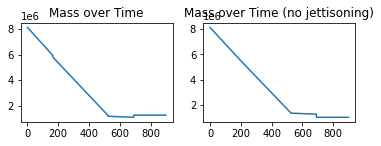

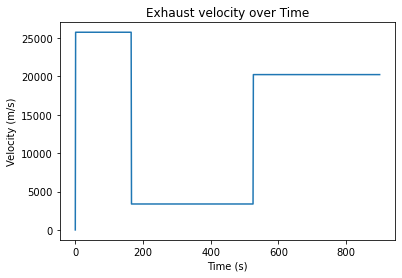

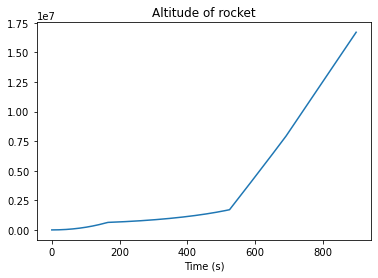

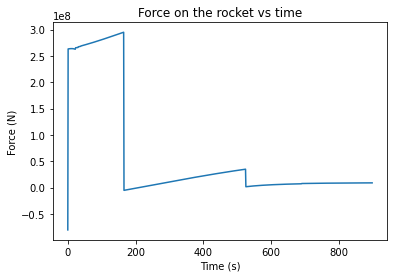

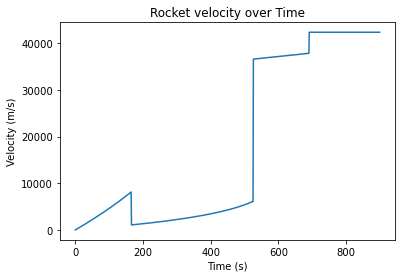

In [17]:
### Ploting Stuffs ###
saveFigs = 0 # 1 if all figures should be saved to .png files or 0 if not

# Rocket Properies
plt.figure(1)
plt.subplot(2,2,1)
plt.plot(t, massData)
plt.title('Mass over Time')
plt.subplot(2,2,2)
plt.plot(t, massDataNoJ)
plt.title('Mass over Time (no jettisoning)')
if saveFigs:
    plt.savefig('MassOverTime.png', dpi=300)

plt.figure(2)
plt.plot(t, exVelocityData)
plt.title('Exhaust velocity over Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
if saveFigs:
    plt.savefig('exVelocityOverTime.png', dpi=300)

plt.figure(3)
plt.plot(t, X[:,0])
plt.title('Altitude of rocket')
plt.xlabel('Time (s)')
if saveFigs:
    plt.savefig('AltitudeOverTime.png', dpi=300)

plt.figure(4)
plt.plot(t, force)
plt.title('Force on the rocket vs time')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
if saveFigs:
    plt.savefig('ForceOverTime.png', dpi=300)

plt.figure(5)
plt.plot(t, velocityData)
plt.title('Rocket velocity over Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
if saveFigs:
    plt.savefig('rocketVelocityOverTime.png', dpi=300)

NameError: name 'h' is not defined

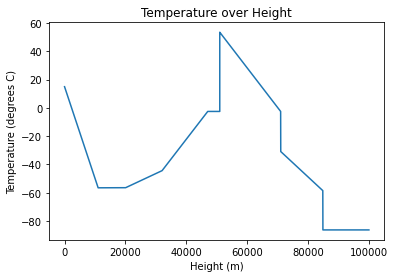

<Figure size 432x288 with 0 Axes>

In [ ]:
# Atmospheric properties
plt.figure(6)
plt.plot(height, airTempData)
plt.title('Temperature over Height')
plt.xlabel('Height (m)')
plt.ylabel('Temperature (degrees C)')
if saveFigs:
    plt.savefig('tempOverHeigt.png', dpi=300)

plt.figure(7)
plt.plot(h[0:65], airRes[0:65])
plt.title('Air resistance as a function of height')
plt.xlabel('Height (m)')
plt.ylabel('Force of the air (N)')
if saveFigs:
    plt.savefig('airResistance.png', dpi=300)

plt.figure(8)
plt.plot(h[0:65], airRes[0:65])
plt.title('Air density as a function of height')
plt.xlabel('Height (m)')
plt.ylabel('Density (kg/m³)')
if saveFigs:
    plt.savefig('airDensity.png', dpi=300)